In [2]:
from math import pi
from braket.circuits import Circuit
from braket.aws import AwsQuantumSimulator, AwsQpu
import time

device_arn = "arn:aws:aqx:::quantum-simulator:aqx:qs1"
device = AwsQuantumSimulator(device_arn)

s3_folder = ("braket-output-823385403234", "outputs")



In [3]:
from math import e, pi, cos, sin
import numpy as np


def cu3(th,phi,lbd):
    a = cos(th/2)
    b = -1j*(e**(1j*lbd))*(sin(th/2))
    c = -1j*(e**(1j*phi))*(sin(th/2))
    d = (e**(1j*(lbd+phi)))*(cos(th/2))
    #print(np.round([[1,0,0,0],[0,1,0,0],[0,0,a,b],[0,0,c,d]],decimals=3))
    return np.array([[1,0,0,0],[0,1,0,0],[0,0,a,b],[0,0,c,d]])

#circ2 = Circuit().x(1).unitary(matrix=cu3(pi/2,pi/2,pi/2),targets=[1,0])

# 

In [4]:
# Function to convert binary fractional to decimal  
def binaryToDecimal(binary, length) : 
    point = binary.find('.') 
    if (point == -1) : 
        point = length  
    intDecimal = 0
    fracDecimal = 0
    twos = 1
    for i in range(point-1, -1, -1) :  
        intDecimal += ((ord(binary[i]) - 
                        ord('0')) * twos)  
        twos *= 2
    twos = 2
    for i in range(point + 1, length): 
        fracDecimal += ((ord(binary[i]) -
                         ord('0')) / twos);  
        twos *= 2.0 
    ans = intDecimal + fracDecimal 
    return ans 

In [25]:


def qpe_c_unitary(circ,n,phase):
    repetitions = 1
    for j in range(n):
        for i in range(repetitions):
            circ.cphaseshift(j, n, 2*pi*phase); 
        repetitions *= 2

def add_qft_n(circ, n):
    for j in range(n):
        circ.h(j)
        for k in range(j+1,n):
            circ.cphaseshift(k, j, pi/float(2**(k-j)))
    for qubit in range(n//2):
        circ.swap(qubit, n-qubit-1)


def add_qft_dagger_n(circ, n):
    for qubit in range(n//2):
        circ.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            circ.cphaseshift(j, m, -pi/float(2**(j-m)))
        circ.h(j)
    for qubit in range(n//2):
        circ.swap(qubit, n-qubit-1)
            

        

# Test for |110>


In [34]:
circ = Circuit()

n=5
phase=0.333

for j in range(n):
    circ.h(j)

# Input Function
circ.x(n)
qpe_c_unitary(circ,n,phase)

#add n Qubit QFT-1
add_qft_dagger_n(circ,n)


print(circ)

T  : |0|     1     |     2     |     3     |     4     |     5     |     6     |     7     |     8     |     9     |    10     |    11     |    12     |    13     |    14     |    15     |    16     |    17     |    18     |    19     |    20     |    21     |    22     |    23     |    24     |    25     |    26     |    27     |    28     |    29     |    30     |    31     | 32 |33|     34     |      35       |            36            |             37              |            38            |      39       |     40     | 41 | 42 |
                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [35]:
task = device.run(circ, s3_folder, shots=4000)

In [36]:
while task.state() != "COMPLETED" :
    print(task.state())
    time.sleep(3)
print(task.state())

INITIALIZED
COMPLETED


In [37]:
result = task.result()
print(f"measurement_counts: {result.measurement_counts}\n")
print(f"measurement_probabilities: {result.measurement_probabilities}\n")

measurement_counts: Counter({'010111': 2623, '010101': 769, '011001': 188, '010011': 119, '011011': 63, '010001': 41, '011101': 36, '001111': 23, '011111': 19, '001011': 14, '001101': 12, '100001': 8, '101011': 8, '110011': 6, '100111': 6, '001001': 6, '000001': 6, '000011': 6, '100101': 5, '100011': 5, '101001': 5, '111011': 4, '110111': 4, '101101': 4, '000111': 4, '110001': 4, '111111': 3, '111101': 3, '110101': 3, '000101': 1, '111001': 1, '101111': 1})

measurement_probabilities: {'010111': 0.65575, '111011': 0.001, '010101': 0.19225, '011001': 0.047, '010001': 0.01025, '010011': 0.02975, '100001': 0.002, '101011': 0.002, '011011': 0.01575, '011101': 0.009, '000101': 0.00025, '110011': 0.0015, '100111': 0.0015, '001101': 0.003, '011111': 0.00475, '001111': 0.00575, '001011': 0.0035, '111001': 0.00025, '001001': 0.0015, '100101': 0.00125, '110111': 0.001, '000001': 0.0015, '101101': 0.001, '000111': 0.001, '111111': 0.00075, '110001': 0.001, '000011': 0.0015, '111101': 0.00075, '10

measurement_of_input_registers: ['01011', '01010', '01100', '01001', '01101', '01000', '01110', '00111', '01111', '00101', '00110', '10000', '10101', '11001', '10011', '00100', '00000', '00001', '10010', '10001', '10100', '11101', '11011', '10110', '00011', '11000', '11111', '11110', '11010', '00010', '11100', '10111']



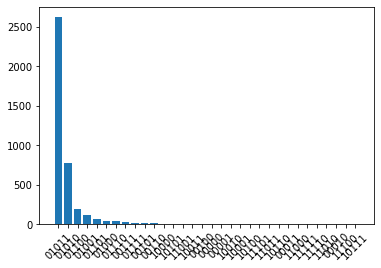

In [40]:
# Categorize measurements by input register values
import matplotlib.pyplot as plt
%matplotlib inline

answer_plot = {}
for measresult in result.measurement_counts.keys():
    measresult_input = measresult[:n] #First n qubits
    if measresult_input in answer_plot:
        answer_plot[measresult_input] += result.measurement_counts[measresult]
    else:
        answer_plot[measresult_input] = result.measurement_counts[measresult] 

print(f"measurement_of_input_registers: {sorted(answer_plot, key=answer_plot.__getitem__,reverse=True),}\n")
#plt.bar(answer_plot.keys(), answer_plot.values())
plt.bar(sorted(answer_plot, key=answer_plot.__getitem__,reverse=True),sorted(answer_plot.values(),reverse=True))
plt.xticks(rotation=45)
plt.show()

In [39]:

for i in sorted(answer_plot, key=answer_plot.__getitem__,reverse=True):
    out=str(i)
    print(i,int(out,2)/2**len(out),answer_plot[i]/10,"%")
    

01011 0.34375 262.3 %
01010 0.3125 76.9 %
01100 0.375 18.8 %
01001 0.28125 11.9 %
01101 0.40625 6.3 %
01000 0.25 4.1 %
01110 0.4375 3.6 %
00111 0.21875 2.3 %
01111 0.46875 1.9 %
00101 0.15625 1.4 %
00110 0.1875 1.2 %
10000 0.5 0.8 %
10101 0.65625 0.8 %
11001 0.78125 0.6 %
10011 0.59375 0.6 %
00100 0.125 0.6 %
00000 0.0 0.6 %
00001 0.03125 0.6 %
10010 0.5625 0.5 %
10001 0.53125 0.5 %
10100 0.625 0.5 %
11101 0.90625 0.4 %
11011 0.84375 0.4 %
10110 0.6875 0.4 %
00011 0.09375 0.4 %
11000 0.75 0.4 %
11111 0.96875 0.3 %
11110 0.9375 0.3 %
11010 0.8125 0.3 %
00010 0.0625 0.1 %
11100 0.875 0.1 %
10111 0.71875 0.1 %
